In [74]:
import re
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# import umap.umap_ as umap

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

In [2]:
# 各フォルダの読み込み
folder_list = glob.glob(r'.\input\spectra_data\*')

# データの区切りを指定（タブ：'\t', コンマ：',', セミコロン：';'）
sep = '[,;\t]'

# excelファイルの保存先のパス
output_path = r'.\output\\'

In [82]:
label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
# label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
# label_list = ['CH3:COOH=0:1', 'CH3:COOH=1:3', 'CH3:COOH=1:1', 'CH3:COOH=3:1', 'CH3:COOH=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'

dataframe_title = '1variable_analysis_data'

data_df = pd.read_excel(dataframe_path + dataframe_title + '.xlsx')
data_df.head()

,Index,raw_peak1,raw_peak2,raw_peak3,raw_peak4,raw_peak5,std_peak1,std_peak2,std_peak3,std_peak4,std_peak5,label
0,CH3-COOH_1-0_01,5103.738329,-190.438947,3683.338417,15008.388339,2495.599180,0.985504,-1.281596,1.603149,2.807891,-1.408493,0
1,CH3-COOH_1-0_02,7812.295705,-194.556679,4414.272363,13674.507873,2396.694976,2.357140,-1.341189,2.553350,3.504776,-1.522716,0
2,CH3-COOH_1-0_03,6766.516954,-197.440682,4061.869953,15787.879885,2984.004149,1.827549,-1.262702,2.205239,4.876685,-0.896542,0
3,CH3-COOH_1-0_04,6495.640211,-140.306765,3963.427044,16377.685418,2759.395509,1.690375,-1.186554,1.991127,2.524528,-1.136014,0
4,CH3-COOH_1-0_05,7921.366032,-250.325583,4436.995675,15268.477283,2591.922039,2.412374,-1.365968,2.478621,3.846731,-1.314570,0


In [83]:
# 特徴量とラベルの分離
data_label = data_df['label']
data_df = data_df.drop(['Index', 'label'], axis=1)

In [157]:
analysis_data_df = data_df[['std_peak5']]

# Linear SVC

## クロスバリデーションでの予測

In [158]:
# kernel:rbf(ガウス関数) その他：linear(線形回帰)、poly(多項式展開)、sigmoidなどがある
def linear_svc(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = LinearSVC(C=C, max_iter=5000)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-pack

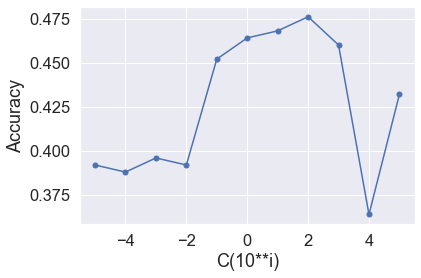

In [159]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = linear_svc(10**i, analysis_data_df, data_label)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [160]:
cm_linear_svc, accuracy_linear_svc = linear_svc(100, analysis_data_df, data_label)
print('Accuracy:', accuracy_linear_svc)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.472


<AxesSubplot:>

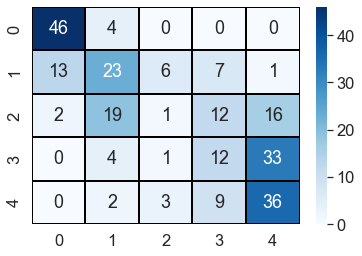

In [161]:
sns.set(font_scale=1.5)
sns.heatmap(cm_linear_svc, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データでの予測

In [100]:
def train_linear_svc(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    svm_model = LinearSVC(C=C, max_iter=5000)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [109]:
train_cm_linear_svc, train_accuracy_linear_svc = train_linear_svc(0.1, analysis_data_df, data_label)
print('Accuracy:', train_accuracy_linear_svc)

Accuracy: 0.4


c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<AxesSubplot:>

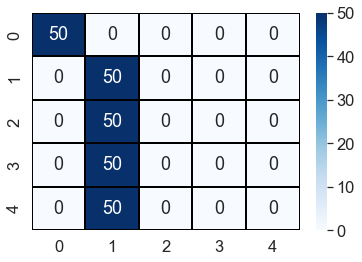

In [110]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_linear_svc, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Perceptron

## クロスバリデーションでの予測

In [103]:
def perceptron(data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        per_model = Perceptron()
        per_model.fit(train_x, train_y)
        y_pred = per_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [104]:
cm_per, accuracy_per = perceptron(analysis_data_df, data_label)
print('Accuracy:', accuracy_per)

Accuracy: 0.224


<AxesSubplot:>

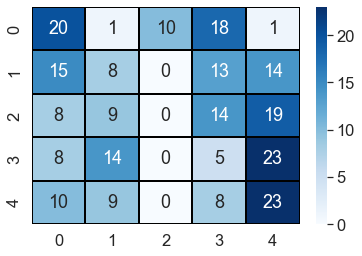

In [105]:
sns.set(font_scale=1.5)
sns.heatmap(cm_per, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Logistic Regression

In [106]:
def logistic(data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        log_model = LogisticRegression()
        log_model.fit(train_x, train_y)
        y_pred = log_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [107]:
cm_log, accuracy_log = perceptron(analysis_data_df, data_label)
print('Accuracy:', accuracy_log)

Accuracy: 0.224


<AxesSubplot:>

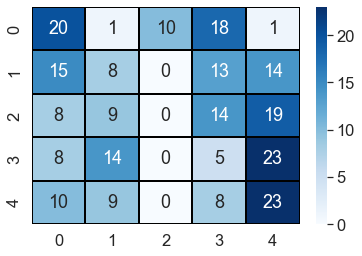

In [108]:
sns.set(font_scale=1.5)
sns.heatmap(cm_log, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# スペクトルの2次元可視化

## データの読み込み

In [117]:
# label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
# label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
CH3_SH_label_list = ['CH3:SH=1:0', 'CH3:SH=3:1', 'CH3:SH=1:1', 'CH3:SH=1:3', 'CH3:SH=0:1']

CH3_COOH_OH_NH2_label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1',
                             'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1',
                             'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

CH3_COOH_OH_NH2_SH_label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1',
                                 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1',
                                 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1',
                                 'CH3:SH=3:1', 'CH3:SH=1:1', 'CH3:SH=1:3', 'CH3:SH=0:1', 'CH3:SH=0:2', 'CH3:SH=0:3']

# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'

# pickleファイルの読み込み
all_title = 'CH3_COOH_OH_NH2_SH_standard_df'
ch3_cooh_oh_nh2_title = "CH3_COOH_OH_NH2_standard_df"
ch3_sh_title = 'CH3_SH_standard_df'

all_df = pd.read_pickle(dataframe_path + all_title + '.pkl')
ch3_cooh_oh_nh2_df = pd.read_pickle(dataframe_path + ch3_cooh_oh_nh2_title + '.pkl')
# ch3_sh_df = pd.read_pickle(dataframe_path + ch3_sh_title + '.pkl')

# 特徴量とラベルの分離
all_label = all_df['label']
ch3_cooh_oh_nh2_label = ch3_cooh_oh_nh2_df['label']
# ch3_sh_label = ch3_sh_df["label"]
all_df = all_df.drop('label', axis=1)
ch3_cooh_oh_nh2_df = ch3_cooh_oh_nh2_df.drop('label', axis=1)
# ch3_sh_df = ch3_sh_df.drop('label', axis=1)

## 前処理

### サンプル方向の標準化

In [4]:
std_scaler = StandardScaler()
std_series = std_scaler.fit_transform(all_df)
all_std_df = pd.DataFrame(std_series, columns=all_df.columns)
all_std_df.head()

Raman Shift,199.147424,201.192791,203.237476,205.281480,207.324801,209.367441,211.409400,213.450678,215.491276,217.531194,...,1735.286945,1736.849012,1738.410618,1739.971761,1741.532444,1743.092665,1744.652426,1746.211725,1747.770565,1749.328943
0,1.247181,0.868209,1.555996,1.045583,0.933379,0.393315,0.702769,0.871934,1.082715,0.945042,...,0.404457,0.537863,0.415094,0.444530,0.580834,0.796188,0.544566,0.744504,0.675985,0.851573
1,0.691772,0.418526,0.312607,0.256877,0.388395,0.394325,0.095312,0.544250,0.808800,0.316266,...,0.483894,0.380699,0.085996,0.464621,0.531023,0.316258,0.350379,0.426757,0.642998,0.341315
2,0.574766,-0.076804,0.021217,0.067195,-0.043919,-0.013891,0.380885,0.325280,0.751765,0.427424,...,0.198231,0.163307,0.219468,0.438343,0.262045,0.125290,0.413056,0.528591,0.470794,0.500403
3,0.655514,1.032033,0.433000,0.754474,0.497626,0.412063,0.878327,0.608008,0.700439,0.599852,...,0.236280,0.445149,0.181521,0.365170,0.308342,0.381651,0.360070,0.480926,0.605105,0.446798
4,1.472030,0.647916,0.347040,0.523260,1.008541,0.172838,0.273220,0.810038,0.554315,0.539362,...,0.531580,0.484378,0.455633,0.517028,0.516439,0.467531,0.379205,0.635211,0.762108,0.602045


### 特徴量選択

In [118]:
def lasso(X, y, mu, epsilon=0.01):
    """
    Lassoを用いた回帰係数の計算
    params X: 説明変数
    params y: 目的変数
    params mu: パラメータ
    params epsilon: 収束の閾値
    return beta: 回帰係数
    """

    # 解の初期値を適当に定める
    beta = np.random.rand(X.shape[1])

    while True:
        # リッジ回帰近似
        B = np.diag(beta)
        beta_new = np.linalg.inv(X.T @ X + mu * np.linalg.pinv(abs(B))) @ X.T @ y

        # 収束判定
        if np.linalg.norm(beta - beta_new.T) < epsilon:
            break

        beta = np.squeeze(beta_new)

    return beta

def nc(X, gamma = 0.99):
    """
    NC法を用いた類似度行列の計算
    param X: 説明変数
    param gamma: 相関係数の有無の判定の閾値
    return: 類似度行列
    """

    N, _ = X.shape
    S = np.zeros([N, N])
    X = X.T

    # 類似度行列の計算
    for i in range(N):
        # クエリを全てのサンプルから引く
        Xq = X[:, i].reshape(-1, 1)
        Xs = X
        Xm = Xs - Xq

        # 相関係数の計算
        V = (Xm.T @ Xm) / (N - 1)
        d = np.sqrt(np.diag(V)).reshape(-1, 1)
        D = d @ d.T
        R = np.divide(V, D, out = np.zeros_like(V), where = D != 0)
        # NaNの除去
        R = np.nan_to_num(R)
        ZERO_DIAG = (np.eye(N) - 1) * -1
        R = R * ZERO_DIAG

        # 相関係数を有するサンプルのペアに重みを与える
        R = np.abs(R)
        R[R > gamma] = 1
        R[R < gamma] = 0

        # 類似度行列の更新
        S += R

    return S

def ncsc(X, n_clusters, gamma = 0.99):
    """
    NCSCを用いて相関関係に基づいたクラスタリングを実行
    params X: 説明変数
    params n_clusters: 分割するクラスタの数
    params gamma: 相関関係の有無の判定の閾値
    return: それぞれのサンプルのクラスタラベル
    """

    # NC法による類似度行列の構築
    S = nc(X)

    # スペクトラルクラスタリングの実行
    clustering = SpectralClustering(n_clusters, affinity = 'precomputed', assign_labels = 'discretize', random_state = 0).fit(S)
    labels = clustering.labels_

    return labels

def lda_prediction(n_comp, data_df, label):
    """
    LDAによる分類モデル
    params n_comp: 次元数
    param data_df: 説明変数のデータフレーム
    param label: 目的変数
    return cm: 予測結果の混同行列
    return Accuracy: 予測の正解率
    """

    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X[train_idx, :], X[val_idx, :]
        train_y, val_y = y[train_idx], y[val_idx]

        lda_model = LDA(n_components=n_comp)
        lda_model.fit(train_x, train_y)
        y_pred = lda_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

def valselect(X, y, labels, prediction_model, n_clusters, n_sel_clusters):
    """
    NCSCの結果を用いて変数選択
    param X: 説明変数
    param y: 目的変数
    param R: 潜在変数
    param labels: クラスタリングされたラベル(NCSCの出力)
    param n_clusters: NCSCによって分割するクラスタの数
    param n_sel_clusters: 選択るするクラスタの数
    return sel_clusters: 選択された変数グループのインデックス
    return sel_var: 選択された変数グループに属する変数のインデックス
    """

    labels = np.array(labels)
    accuracy_array = np.zeros([n_clusters])

    for c in range(n_clusters):
        idx = labels == c
        X_cls = X[:, idx]
        # 変数クラスタごとに
        if len(X_cls) != 0:
            _, pred_accuracy = prediction_model(2, X_cls, y)
            accuracy_array[c] = pred_accuracy

    # 計算された正解率から変数グループを選択
    idx = np.argsort(accuracy_array)[::-1]
    sel_clusters = idx[:n_sel_clusters]
    sel_var = [i for i, l in enumerate(labels) if l in sel_clusters]

    return sel_clusters, sel_var

#### k-meansによる特徴量選択

In [157]:
# 分割する変数グループ数
n_clusters = 8
# 予測に使用する変数グループ数
n_sel_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(np.array(all_df.T))
all_kmeans_labels = kmeans.labels_
all_sel_clusters_kmeans, all_sel_var_kmeans = valselect(np.array(all_df), all_label, all_kmeans_labels, lda_prediction, n_clusters, n_sel_clusters)

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(np.array(ch3_cooh_oh_nh2_df.T))
ch3_cooh_oh_nh2_kmeans_labels = kmeans.labels_
sel_clusters_kmeans, sel_var_kmeans = valselect(np.array(ch3_cooh_oh_nh2_df), ch3_cooh_oh_nh2_label, ch3_cooh_oh_nh2_kmeans_labels,
                                                lda_prediction, n_clusters, n_sel_clusters)

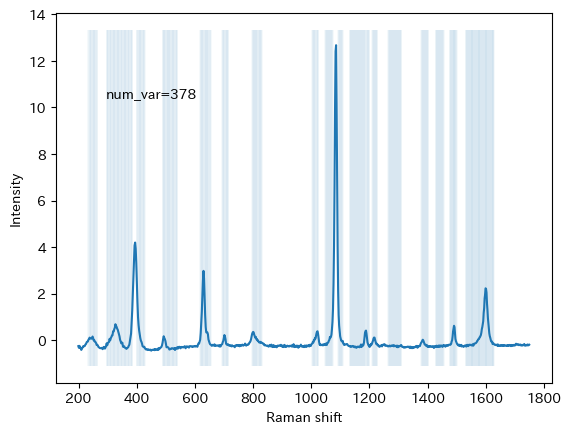

In [158]:
fig, ax = plt.subplots()
ax.set_xlabel("Raman shift")
ax.set_ylabel("Intensity")

ax.plot(all_df.iloc[0])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.vlines(all_df.columns[sel_var_kmeans], ymin, ymax, linewidth=0.3, alpha=0.2)

num_text = f'num_var={len(sel_var_kmeans)}'
posx = (xmax - xmin) * 0.1 + xmin
posy = (ymax - ymin) * 0.8 + ymin
ax.text(posx, posy, num_text)

plt.show()

In [159]:
# データセットの再構築
all_kmeans_df = all_df.iloc[:, sel_var_kmeans]
print(all_kmeans_df.shape)

ch3_cooh_oh_nh2_kmeans_df = ch3_cooh_oh_nh2_df.iloc[:, sel_var_kmeans]
print(ch3_cooh_oh_nh2_kmeans_df.shape)

(800, 378)
(650, 378)


#### NCSCによる特徴量選択

In [126]:
# NCSCによって分割する変数グループ数
n_clusters = 20
# 検量線に使用する変数グループ数
n_sel_clusters = 3

all_ncsc_labels = ncsc(np.array(all_df.T), n_clusters, gamma = 0.95)
all_sel_clusters_ncsc, all_sel_var_ncsc = valselect(np.array(all_df), all_label, all_ncsc_labels, lda_prediction, n_clusters, n_sel_clusters)

ch3_cooh_oh_nh2_ncsc_labels = ncsc(np.array(ch3_cooh_oh_nh2_df.T), n_clusters, gamma = 0.95)
sel_clusters_ncsc, sel_var_ncsc = valselect(np.array(ch3_cooh_oh_nh2_df), ch3_cooh_oh_nh2_label, ch3_cooh_oh_nh2_ncsc_labels,
                                            lda_prediction, n_clusters, n_sel_clusters)

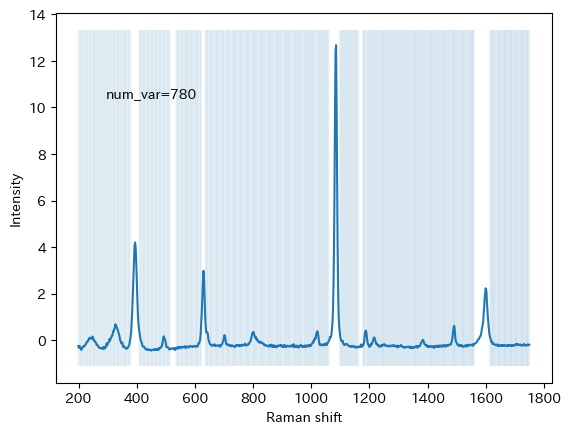

In [127]:
fig, ax = plt.subplots()
ax.set_xlabel("Raman shift")
ax.set_ylabel("Intensity")

ax.plot(all_df.iloc[0])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.vlines(all_df.columns[sel_var_ncsc], ymin, ymax, linewidth=0.3, alpha=0.2)

num_text = f'num_var={len(sel_var_ncsc)}'
posx = (xmax - xmin) * 0.1 + xmin
posy = (ymax - ymin) * 0.8 + ymin
ax.text(posx, posy, num_text)

plt.show()

In [128]:
# データセットの再構築
all_ncsc_df = all_df.iloc[:, sel_var_ncsc]
print(all_ncsc_df.shape)

ch3_cooh_oh_nh2_ncsc_df = ch3_cooh_oh_nh2_df.iloc[:, sel_var_ncsc]
print(ch3_cooh_oh_nh2_ncsc_df.shape)

(800, 780)
(650, 780)


## PCA

In [59]:
def pca_2d_plot(df, df_label, label_list):
    pca = PCA(n_components=2)

    pca_X = pca.fit_transform(df.values)
    pca_result_df = pd.DataFrame(pca_X)
    pca_result_df.columns = ['PC1', 'PC2']
    pca_result_df['label'] = df_label.values

    color_list = ['lightgray', 'lightblue', 'royalblue', 'blue', 'darkblue', 'lightsalmon', 'salmon', 'red', 'darkred',
                  'lightgreen', 'limegreen', 'forestgreen', 'darkgreen', 'khaki', 'gold', 'goldenrod', 'darkgoldenrod']

    for i in range(np.unique(df_label).size):
        data = pca_result_df[pca_result_df['label'] == i]
        plt.scatter(data['PC1'], data['PC2'], c=color_list[i], label=label_list[i])

    # 寄与率の算出
    exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns=['PC1', 'PC2'])
    print(exp_var_ratio)

    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=df.columns, index=['PC1', 'PC2'])

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(loc='best')
    plt.show()

    return pca_result_df, pca_vec_df

        PC1       PC2
0  0.436617  0.301319


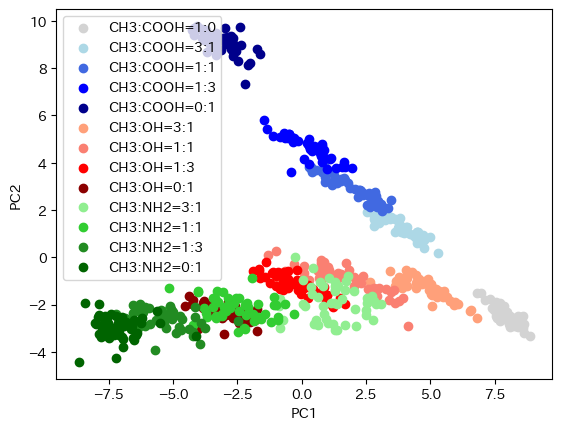

In [61]:
standard_pca_result_df, standard_pca_vec_df = pca_2d_plot(ch3_cooh_oh_nh2_kmeans_df, ch3_cooh_oh_nh2_label, CH3_COOH_OH_NH2_label_list)

In [ ]:
# 固有ベクトルの可視化
standard_pca_vec_df.T.plot()

## tSNE

In [62]:
# tSNEのパラメータ検討
def create_2d_tsne(target_X, y, y_labels, perplexity_list=[5, 10, 20, 30, 40, 50, 100]):
    """
    params target_X: 特徴量データ
    params y: ラベルデータ
    params y_labels: ラベルのリスト（ラベルのユニーク）
    """
    fig, axes = plt.subplots(nrows=1, ncols=len(perplexity_list), figsize=(5*len(perplexity_list), 4))
    for ax, perplexity in zip(axes.flatten(), perplexity_list):

        tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(target_X)
        for each_label in y_labels:
            c_plot_bool = y == y_labels.index(each_label)
            ax.scatter(Y[c_plot_bool, 0], Y[c_plot_bool, 1], label="{}".format(each_label))

        ax.legend()
        ax.set_title("perplexity: {}".format(perplexity))

    plt.show()

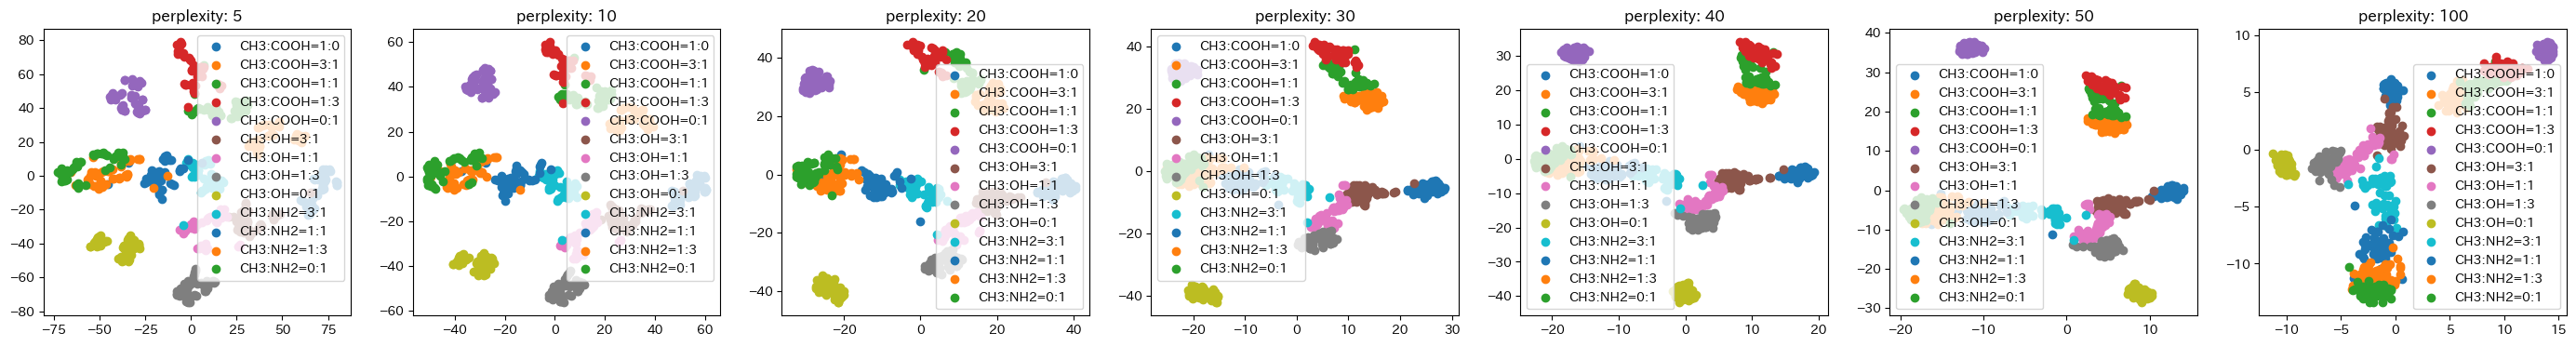

In [63]:
create_2d_tsne(ch3_cooh_oh_nh2_kmeans_df, ch3_cooh_oh_nh2_label, CH3_COOH_OH_NH2_label_list)

In [64]:
def tsne_2D_plot(df, df_label, label_list, perplexity=30):
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity, init='pca')

    X = tsne.fit_transform(df.values)
    tsne_result_df = pd.DataFrame(X)
    tsne_result_df.columns = ['tSNE1', 'tSNE2']
    tsne_result_df['label'] = df_label.values

    color_list = ['lightgray', 'lightblue', 'royalblue', 'blue', 'darkblue', 'lightsalmon', 'salmon', 'red', 'darkred',
                  'lightgreen', 'limegreen', 'forestgreen', 'darkgreen', 'khaki', 'gold', 'goldenrod', 'darkgoldenrod']

    for i in range(np.unique(df_label).size):
        data = tsne_result_df[tsne_result_df['label'] == i]
        plt.scatter(data['tSNE1'], data['tSNE2'], c=color_list[i], label=label_list[i])

    plt.xlabel('tSNE1')
    plt.ylabel('tSNE2')
    plt.legend(loc='best')
    plt.show()

    return tsne_result_df

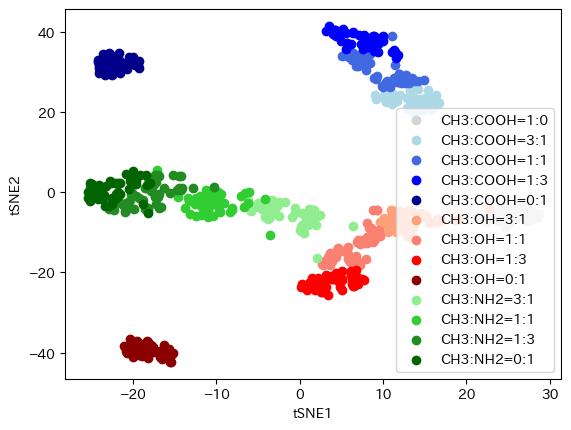

In [65]:
standard_tsne_result_df = tsne_2D_plot(ch3_cooh_oh_nh2_kmeans_df, ch3_cooh_oh_nh2_label, CH3_COOH_OH_NH2_label_list)

## LDA

In [122]:
def lda_2D_plot(df, df_label, label_list):
    """
    params df: 特徴量データ（データフレーム型）
    params df_label: ラベルデータ
    params label_list: ラベルのリスト（ラベルのユニーク）
    return: LDAでの次元削減結果
    """
    lda = LDA(n_components=2)
    X_r2 = lda.fit(df, df_label).transform(df)

    color_list = ['lightgray', 'lightblue', 'royalblue', 'blue', 'darkblue', 'lightsalmon', 'salmon', 'red', 'darkred',
                  'lightgreen', 'limegreen', 'forestgreen', 'darkgreen', 'khaki', 'gold', 'goldenrod', 'darkgoldenrod']

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

    for i in range(np.unique(df_label).size):
        plt.scatter(X_r2[df_label == i, 0], X_r2[df_label == i, 1],
        c=color_list[i], label=label_list[i])

    # ldaの結果をデータフレーム化
    lda_result_df = pd.DataFrame(X_r2)
    lda_result_df.columns = ['LDA1', 'LDA2']
    lda_result_df['label'] = df_label.values

    # 重みベクトルの取得
    lda_weight_vec_df = pd.DataFrame(lda.coef_, columns=df.columns, index=label_list)

    plt.xlabel('LDA1')
    plt.ylabel('LDA2')
    plt.legend(loc='best')
    plt.show()

    return lda_result_df, lda_weight_vec_df

In [38]:
N_COMP = 100

pca = PCA(n_components=N_COMP)

pca_X = pca.fit_transform(all_df.values)
all_pca_df = pd.DataFrame(pca_X)

# 寄与率の算出
std_data_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns=[f'PC{n+1}' for n in range(N_COMP)])

# 寄与率の確認
print(std_data_exp_var_ratio)
print("合計:", np.sum(std_data_exp_var_ratio, axis=1).values)

       PC1       PC2       PC3      PC4       PC5       PC6       PC7  \
0  0.62239  0.127949  0.097137  0.03649  0.025799  0.018552  0.014141   

        PC8       PC9      PC10  ...      PC91      PC92      PC93      PC94  \
0  0.008592  0.005887  0.003555  ...  0.000091  0.000089  0.000088  0.000086   

       PC95      PC96      PC97      PC98     PC99     PC100  
0  0.000085  0.000083  0.000082  0.000081  0.00008  0.000078  

[1 rows x 100 columns]
合計: [0.99074415]


explained variance ratio (first two components): [0.72282297 0.11604668]


IndexError: list index out of range

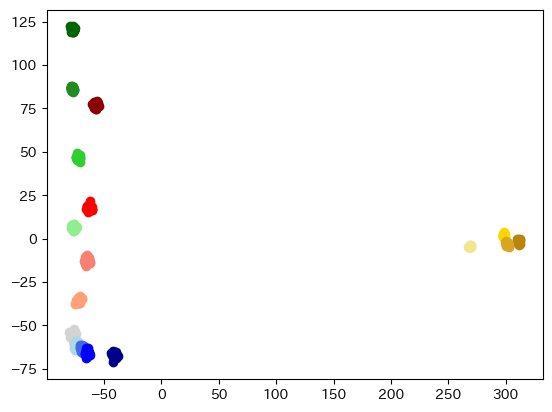

In [134]:
lda_result_df, lda_weight_vec_df = lda_2D_plot(all_df, all_label, CH3_COOH_OH_NH2_SH_label_list)

explained variance ratio (first two components): [0.81496449 0.09288853]


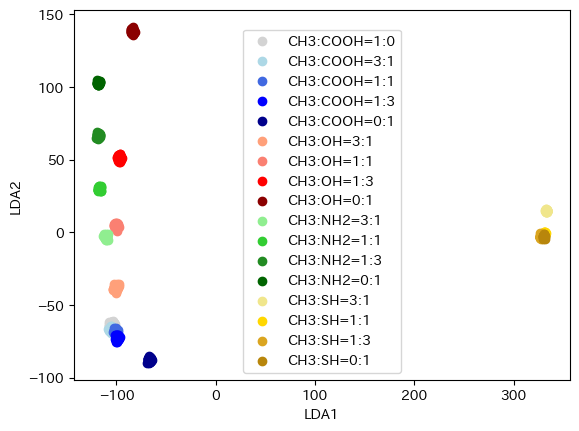

In [29]:
ncsc_lda_result_df, ncsc_lda_weight_vec_df = lda_2D_plot(all_ncsc_df, all_label, CH3_COOH_OH_NH2_SH_label_list)

explained variance ratio (first two components): [0.47155929 0.28749574]


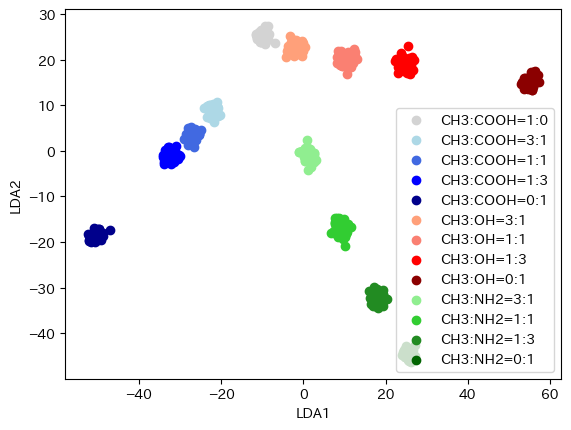

In [67]:
kmeans_lda_result_df, kmeans_lda_weight_vec_df = lda_2D_plot(ch3_cooh_oh_nh2_kmeans_df, ch3_cooh_oh_nh2_label, CH3_COOH_OH_NH2_label_list)

In [33]:
scaler = MinMaxScaler()
series = scaler.fit_transform(lda_result_df[["LDA1", "LDA2"]])
lda_result_df_norm = pd.DataFrame(series)

series = scaler.fit_transform(ncsc_lda_result_df[["LDA1", "LDA2"]])
ncsc_lda_result_df_norm = pd.DataFrame(series)

series = scaler.fit_transform(kmeans_lda_result_df[["LDA1", "LDA2"]])
kmeans_lda_result_df_norm = pd.DataFrame(series)

print(lda_result_df_norm.shape)
print(ncsc_lda_result_df_norm.shape)
print(kmeans_lda_result_df_norm.shape)

(850, 2)
(850, 2)
(850, 2)


In [56]:
df = (lda_result_df_norm * 2 + kmeans_lda_result_df_norm) / 3
df["label"] = all_label.values.astype(int)

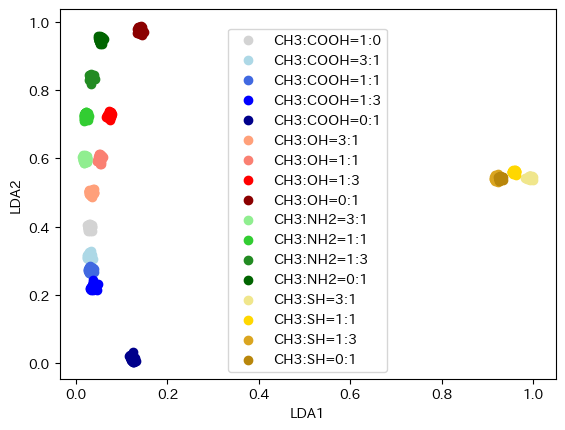

In [57]:
color_list = ['lightgray', 'lightblue', 'royalblue', 'blue', 'darkblue', 'lightsalmon', 'salmon', 'red', 'darkred',
              'lightgreen', 'limegreen', 'forestgreen', 'darkgreen', 'khaki', 'gold', 'goldenrod', 'darkgoldenrod']

for i in range(np.unique(all_label).size):
    plt.scatter(df.loc[df["label"] == i, 0], df.loc[df["label"] == i, 1],
    c=color_list[i], label=CH3_COOH_OH_NH2_SH_label_list[i])

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.legend(loc='best')
plt.show()

### SMVでの精度評価

In [75]:
# kernel:rbf(ガウス関数) その他：linear(線形回帰)、poly(多項式展開)、sigmoidなどがある
def svm_only(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC(C=C)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

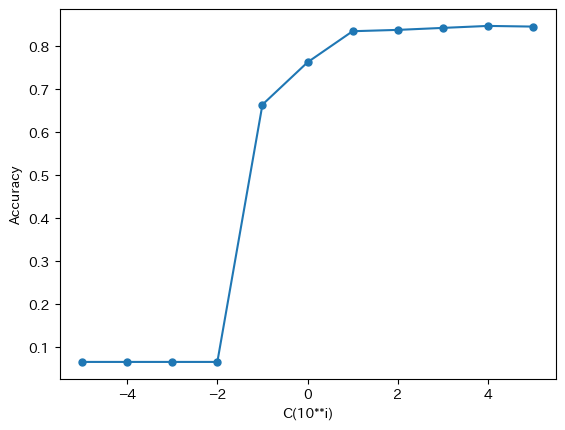

In [76]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = svm_only(10**i, standard_pca_result_df[["PC1", "PC2"]], standard_pca_result_df["label"])
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [80]:
cm_svm, accuracy_svm = svm_only(10000, standard_pca_result_df[["PC1", "PC2"]], standard_pca_result_df["label"])
print('Accuracy:', accuracy_svm)

Accuracy: 0.8476923076923077


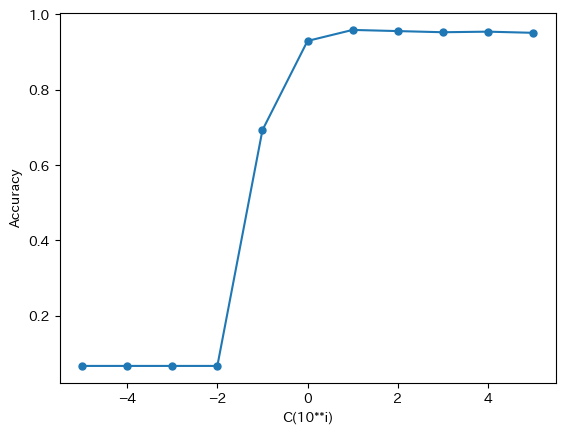

In [82]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = svm_only(10**i, standard_tsne_result_df[["tSNE1", "tSNE2"]], standard_pca_result_df["label"])
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [83]:
cm_svm, accuracy_svm = svm_only(10, standard_tsne_result_df[["tSNE1", "tSNE2"]], standard_pca_result_df["label"])
print('Accuracy:', accuracy_svm)

Accuracy: 0.9584615384615385


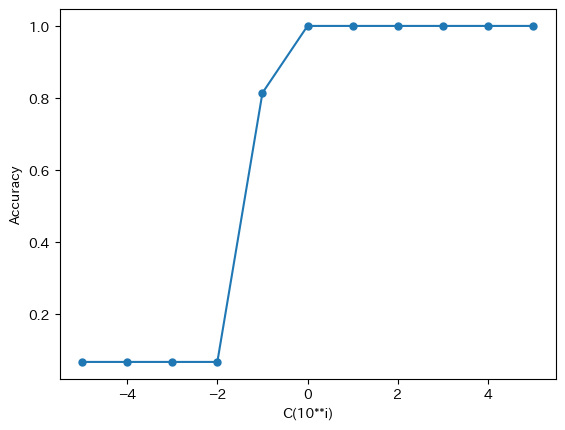

In [85]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = svm_only(10**i, kmeans_lda_result_df[["LDA1", "LDA2"]], standard_pca_result_df["label"])
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [86]:
cm_svm, accuracy_svm = svm_only(1, kmeans_lda_result_df[["LDA1", "LDA2"]], standard_pca_result_df["label"])
print('Accuracy:', accuracy_svm)

Accuracy: 1.0


### 異常値検出

In [123]:
def lda_2D_plot_anomal(df, df_label, test_df, test_data_label, label_list):
    lda = LDA(n_components=2)
    X_r2 = lda.fit(df, df_label).transform(test_df)

    color_list = ['lightgray', 'lightblue', 'royalblue', 'blue', 'darkblue', 'lightsalmon', 'salmon', 'red', 'darkred',
                  'lightgreen', 'limegreen', 'forestgreen', 'darkgreen', 'khaki', 'gold', 'goldenrod', 'darkgoldenrod']

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

    for i in range(np.unique(test_data_label).size):
        plt.scatter(X_r2[test_data_label == i, 0], X_r2[test_data_label == i, 1],
        c=color_list[i], label=label_list[i])

    # ldaの結果をデータフレーム化
    lda_result_df = pd.DataFrame(X_r2)
    lda_result_df.columns = ['LDA1', 'LDA2']
    lda_result_df['label'] = test_data_label.values

    plt.xlabel('LDA1')
    plt.ylabel('LDA2')
    plt.legend(loc='best')
    plt.show()

    return lda_result_df

explained variance ratio (first two components): [0.47067456 0.27250756]


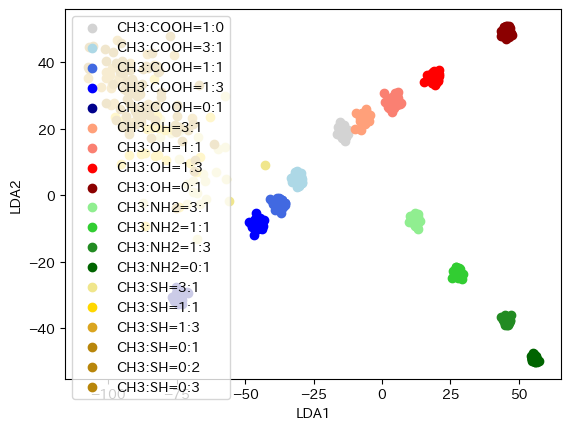

In [130]:
standard_lda_result_df = lda_2D_plot_anomal(ch3_cooh_oh_nh2_df, ch3_cooh_oh_nh2_label, all_df, all_label, CH3_COOH_OH_NH2_SH_label_list)

explained variance ratio (first two components): [0.49508383 0.2361769 ]


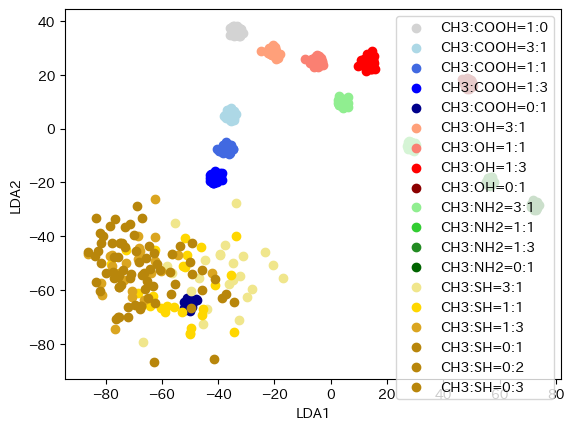

In [129]:
standard_lda_result_df = lda_2D_plot_anomal(ch3_cooh_oh_nh2_ncsc_df, ch3_cooh_oh_nh2_label, all_ncsc_df, all_label, CH3_COOH_OH_NH2_SH_label_list)

explained variance ratio (first two components): [0.47582503 0.28657068]


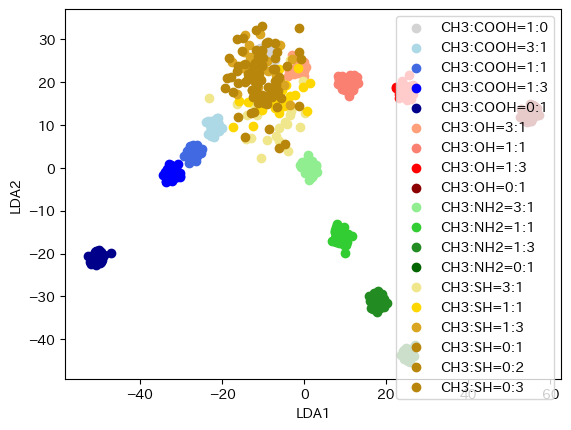

In [160]:
kmeans_lda_result_df_anomal = lda_2D_plot_anomal(ch3_cooh_oh_nh2_kmeans_df, ch3_cooh_oh_nh2_label, all_kmeans_df, all_label, CH3_COOH_OH_NH2_SH_label_list)

In [133]:
graph_title = 'standard_pca_result'
standard_pca_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'standard_tsne_result'
standard_tsne_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'kmeans_lda_result'
kmeans_lda_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'kmeans_lda_result_anomal'
kmeans_lda_result_df_anomal.to_excel(output_path + graph_title + '.xlsx', index=False)

In [110]:
# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'

# pickleファイルの読み込み
df_title = 'CH3_COOH_OH_NH2_standard_df'
connect_title = 'CH3_COOH_SH_standard_df'

df = pd.read_pickle(dataframe_path + df_title + '.pkl')
connect_df = pd.read_pickle(dataframe_path + connect_title + '.pkl')

In [111]:
connect_df.columns = df.columns

In [112]:
a = connect_df[connect_df.label == 0].copy()
a["label"] = 13

b = connect_df[connect_df.label == 1].copy()
b["label"] = 14

c = connect_df[connect_df.label == 2].copy()
c["label"] = 15

d = connect_df[connect_df.label == 3].copy()
d["label"] = 16

e = connect_df[connect_df.label == 4].copy()
e["label"] = 17

f = connect_df[connect_df.label == 5].copy()
f["label"] = 18

In [113]:
temp_df = pd.concat([a, b, c, d, e, f])
temp_df

Raman Shift,199.147423618928,201.192791188876,203.237476388369,205.281479548654,207.324801000766,209.367441075527,211.409400103543,213.450678415207,215.491276340697,217.53119420998,...,1736.84901220951,1738.41061757765,1739.97176141826,1741.53244392806,1743.09266530367,1744.65242574159,1746.21172543821,1747.7705645898,1749.32894339254,label
CH3-COOH-SH_5-5-1_01,-0.506023,-0.521267,-0.513148,-0.528628,-0.601861,-0.722173,-0.577903,-0.559694,-0.524522,-0.478791,...,-0.300262,-0.286212,-0.325531,-0.247445,-0.241941,-0.253517,-0.262962,-0.208369,-0.249839,13
CH3-COOH-SH_5-5-1_02,-0.651908,-0.545587,-0.715961,-0.661610,-0.668191,-0.489551,-0.557214,-0.564251,-0.449881,-0.642591,...,-0.291433,-0.280971,-0.364715,-0.305633,-0.216162,-0.281678,-0.386701,-0.209107,-0.350599,13
CH3-COOH-SH_5-5-1_03,-0.536962,-0.462783,-0.659868,-0.521985,-0.576291,-0.596859,-0.508383,-0.502895,-0.482496,-0.439653,...,-0.271737,-0.241382,-0.226092,-0.259758,-0.044912,-0.244264,-0.236524,-0.319158,-0.228589,13
CH3-COOH-SH_5-5-1_04,-0.683340,-0.597453,-0.734285,-0.601462,-0.638504,-0.709103,-0.626879,-0.606028,-0.513023,-0.826328,...,-0.158368,-0.178931,-0.285734,-0.131057,-0.310197,-0.222294,-0.256795,-0.363627,-0.342505,13
CH3-COOH-SH_5-5-1_05,-0.600253,-0.778583,-0.840892,-0.835585,-0.746526,-0.828654,-0.807665,-0.622246,-0.820998,-0.703645,...,-0.170591,-0.237948,-0.369850,-0.198409,-0.262548,-0.187926,-0.187530,-0.209727,-0.212565,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH3-NH2-SH_5-12-3_21,-0.854245,-0.796631,-0.809271,-0.694544,-0.881690,-0.841594,-0.740002,-0.755411,-0.705072,-0.799358,...,-0.287029,-0.310829,-0.304885,-0.296821,-0.222887,-0.306206,-0.264157,-0.256112,-0.282071,18
CH3-NH2-SH_5-12-3_22,-0.698697,-0.805672,-0.761982,-0.772924,-0.725857,-0.598977,-0.684789,-0.865200,-0.486165,-0.657742,...,-0.307727,-0.352968,-0.309187,-0.305377,-0.261599,-0.346814,-0.306672,-0.241095,-0.297246,18
CH3-NH2-SH_5-12-3_23,-0.876065,-0.949199,-0.908422,-1.023155,-0.727855,-0.767677,-0.768830,-0.874517,-0.866290,-0.812108,...,-0.288114,-0.342118,-0.323309,-0.289940,-0.278421,-0.276614,-0.313648,-0.377385,-0.256657,18
CH3-NH2-SH_5-12-3_24,-0.725184,-0.712724,-0.753024,-0.679111,-0.792262,-0.756714,-0.795703,-0.823928,-0.799643,-0.639362,...,-0.272478,-0.279638,-0.328544,-0.312113,-0.371912,-0.402674,-0.362656,-0.349864,-0.362483,18


In [114]:
hozon_df = pd.concat([df, temp_df], axis=0)
hozon_df.shape

(800, 870)

In [98]:
np.unique(hozon_df.label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18.])

In [115]:
df_title = 'CH3_COOH_OH_NH2_SHSH_standard_df'
save_df = hozon_df.copy()
save_df.to_pickle(output_path + df_title + '.pkl')